In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df = pd.read_csv("/content/gdrive/MyDrive/1.Kuliah/Semester-7/Machine_Learning/Praktikum/Praktikum04/Data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [ ]:
# cek missing value
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [ ]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [ ]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [ ]:
#1. Mapping kolom Stunting -> biner
map_stunt = {'Stunted': 1, 'Severely Stunted': 1, 'Normal': 0, 'Tall': 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

#2. Mapping kolom Jenis Kelamin -> biner
# Laki-laki = 1, Perempuan = 0
df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype(int)

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    78021
1    21979
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    50179
0    49821
Name: count, dtype: int64


In [ ]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,0.038630,0.004046
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.283855,0.073505
Berat Badan (kg),0.665389,0.626005,1.000000,0.021090,0.045797
Stunting_bin,0.038630,-0.283855,0.021090,1.000000,-0.005981
JK_bin,0.004046,0.073505,0.045797,-0.005981,1.000000


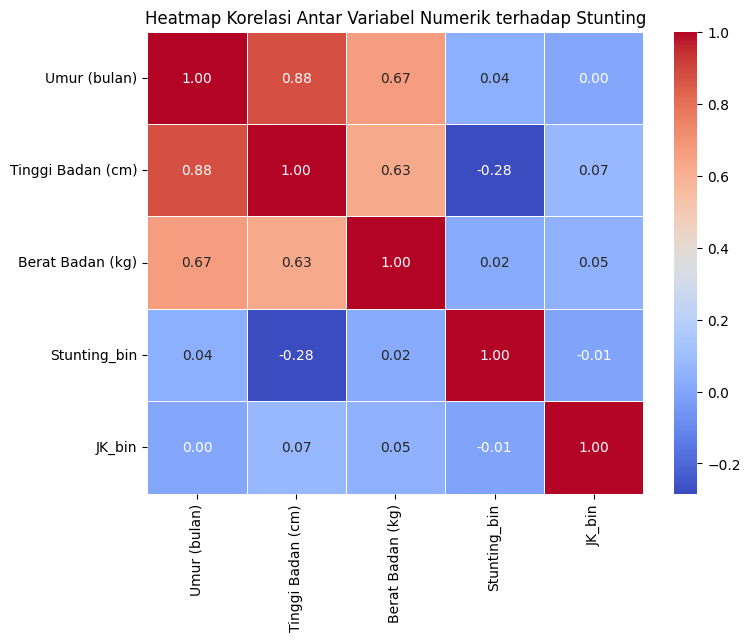

In [ ]:
#Visualisasi heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidth=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik terhadap Stunting", fontsize=12)
plt.show()

In [ ]:
#Fitur numerik dan gender
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

#Gabungan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (100000, 4)
y shape: (100000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (80000, 4)
Data uji: (20000, 4)


In [ ]:
#Scale hanya fitur numerik, gender Langsung pastrough
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

#Latih model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih")

✅ Model Logistic Regression berhasil dilatih


In [ ]:
#prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

#Hitung Metrik
print(f"Akurasi : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC_AUC : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi : 0.9055
Precision : 0.7152
Recall : 0.9472
F1-Score : 0.8150
ROC_AUC : 0.9656


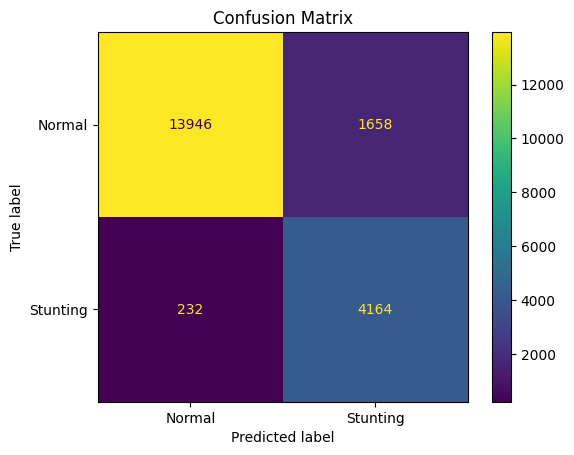

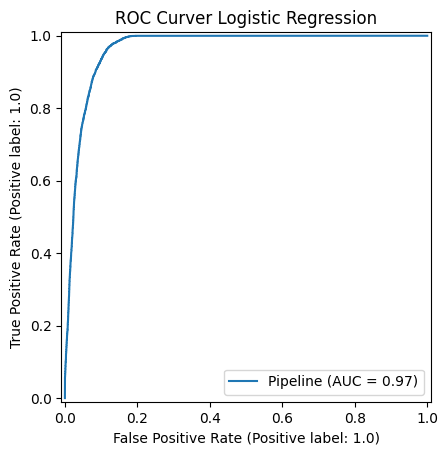

In [ ]:
#Confussion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=['Normal', 'Stunting']
                       ).plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

#ROC Curver
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curver Logistic Regression")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting (0)', 'Stunting (1)']))

                    precision    recall  f1-score   support

Tidak Stunting (0)       0.98      0.89      0.94     15604
      Stunting (1)       0.72      0.95      0.82      4396

          accuracy                           0.91     20000
         macro avg       0.85      0.92      0.88     20000
      weighted avg       0.92      0.91      0.91     20000



In [ ]:
from sklearn.model_selection import cross_val_score
#lakukan cross validation (cv=5 bearti 5-fols)
scores = cross_val_score(clf, X, y, cv=5)

#Tampilkan hasil
print("Skor tiap fols:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar Deviasi:", np.std(scores))

Skor tiap fols: [0.9062  0.9013  0.9052  0.89905 0.9002 ]
Rata-rata akurasi: 0.9023899999999999
Standar Deviasi: 0.0028125433329995106


In [ ]:
#Ambil nama fitur & koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),8.525912,5043.782458
3,JK_bin,1.675944,5.343839
2,Berat Badan (kg),0.661090,1.936903
1,Tinggi Badan (cm),-10.535980,0.000027


In [ ]:
#contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1,0] # 1=laki-laki, 0=perempuan
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:,1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak, 1=Ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak, 1=Ya)"
0,24,79.0,9.2,1,0.998208,1.0
1,10,72.5,7.8,0,0.002094,0.0


Tugas Mandiri 4

In [7]:
df = pd.read_csv("/content/gdrive/MyDrive/1.Kuliah/Semester-7/Machine_Learning/Praktikum/Praktikum04/Data/calonpembelimobil.csv")
df.head()

,ID,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Beli_Mobil
0,1,32,1,0,0,240,1
1,2,49,2,1,1,100,0
2,3,52,1,0,2,250,1
3,4,26,2,1,1,130,0
4,5,45,3,0,2,237,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ID              1000 non-null   int64
 1   Usia            1000 non-null   int64
 2   Status          1000 non-null   int64
 3   Kelamin         1000 non-null   int64
 4   Memiliki_Mobil  1000 non-null   int64
 5   Penghasilan     1000 non-null   int64
 6   Beli_Mobil      1000 non-null   int64
dtypes: int64(7)
memory usage: 54.8 KB


In [9]:
# melihat apakah ada missing value
df.isna().sum()

,0
ID,0
Usia,0
Status,0
Kelamin,0
Memiliki_Mobil,0
Penghasilan,0
Beli_Mobil,0


In [10]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,ID,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Beli_Mobil
ID,1.000000,0.149779,-0.006634,0.014646,0.068555,0.254177,0.168614
Usia,0.149779,1.000000,0.051476,0.019454,0.090926,0.125859,0.100127
Status,-0.006634,0.051476,1.000000,-0.008561,0.048302,0.071714,0.048584
Kelamin,0.014646,0.019454,-0.008561,1.000000,0.035199,-0.054211,-0.147301
Memiliki_Mobil,0.068555,0.090926,0.048302,0.035199,1.000000,0.137823,0.102005
Penghasilan,0.254177,0.125859,0.071714,-0.054211,0.137823,1.000000,0.763930
Beli_Mobil,0.168614,0.100127,0.048584,-0.147301,0.102005,0.763930,1.000000


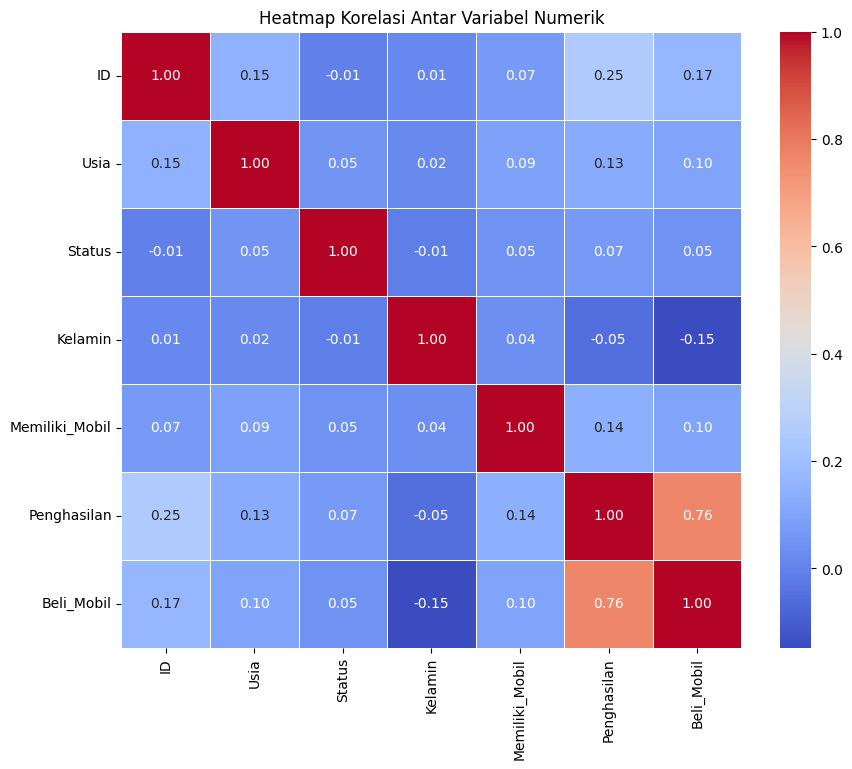

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik", fontsize=12)
plt.show()

In [12]:
feature_num = ['Usia', 'Status', 'Kelamin', 'Memiliki_Mobil']
feature_bin = ['Penghasilan']

use_cols = feature_num + feature_bin + ['Beli_Mobil']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Beli_Mobil']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1000, 5)
y shape: (1000,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
    )

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (800, 5)
Data uji: (200, 5)


In [14]:
prepocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('prepocessing', prepocess),
    ('model', model)
])

# latihan model
clf.fit(X_train, y_train)
print("✅ Model logistic regression berhasil dilatih.")

✅ Model logistic regression berhasil dilatih.


In [15]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# menghitung metrik
print(f"Akurasi     : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision   : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score    : {f1_score (y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC     : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi     : 0.9300
Precision   : 0.9748
F1-Score    : 0.9431
ROC-AUC     : 0.9770


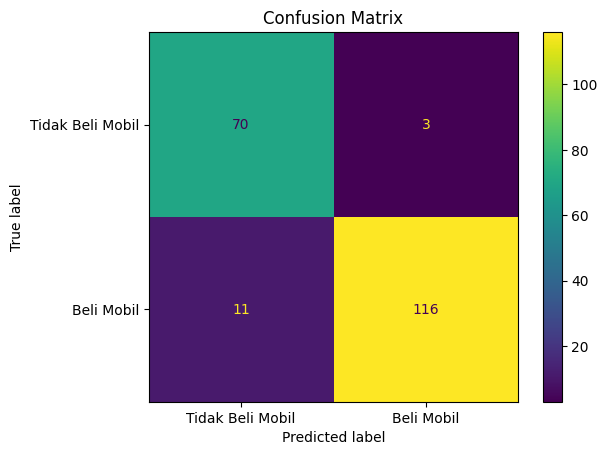

In [16]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=['Tidak Beli Mobil', 'Beli Mobil']
                       ).plot(values_format='d')

plt.title("Confusion Matrix")
plt.show()

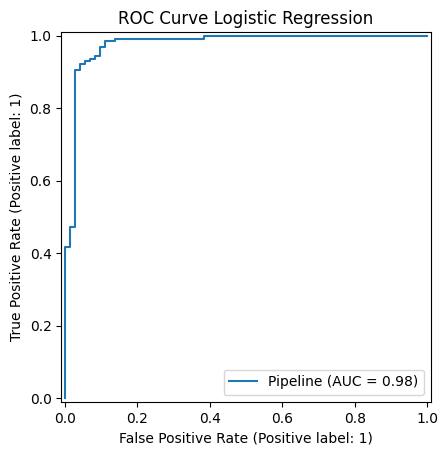

In [17]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Beli Mobil', 'Beli Mobil']))

                  precision    recall  f1-score   support

Tidak Beli Mobil       0.86      0.96      0.91        73
      Beli Mobil       0.97      0.91      0.94       127

        accuracy                           0.93       200
       macro avg       0.92      0.94      0.93       200
    weighted avg       0.93      0.93      0.93       200



In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)

print("Skor setiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))

Skor setiap fold: [0.785 0.91  0.955 0.945 0.94 ]
Rata-rata akurasi: 0.907
Standar deviasi: 0.06281719509815761


In [20]:
feat_names = feature_num + feature_bin
coefss = clf.named_steps['model'].coef_[0]
odds = np.exp(coefss)

coef_df = pd.DataFrame({
    'fitur': feat_names,
    'koefisien (log-odds)': coefss,
    'odds ratio (e^coef)': odds
}).sort_values('odds ratio (e^coef)', ascending=False)

display(coef_df)

,fitur,koefisien (log-odds),odds ratio (e^coef)
3,Memiliki_Mobil,0.083176,1.086733
4,Penghasilan,0.055951,1.057546
0,Usia,-0.082246,0.921045
1,Status,-0.168034,0.845325
2,Kelamin,-0.655173,0.519352


In [21]:
data_baru = pd.DataFrame({
    'Usia'            :[25, 30],
    'Status'          :[1, 0],
    'Kelamin'         :[1, 0],
    'Memiliki_Mobil'  :[2, 0],
    'Penghasilan'     :[700, 65]
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:,1]

hasil = data_baru.copy()
hasil['Prob_Beli_Mobil'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)

,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Prob_Beli_Mobil,"Pred (0=Tidak,1=Ya)"
0,25,1,1,2,700,1.000000,1
1,30,0,0,0,65,0.000235,0
